# Wikimedia movies Pipeline

<div style="position: relative; ">
    <img src="http://www.okynemedialab.com/wp-content/uploads/2019/11/netflix-background-50-Black-1579164_1080x675.jpg" height="300">
</div>

In short this notebook is divided in three sections
1. Download the dataset locally.
2. Process and upload the releavant data to Weaviate.
3. Make some sample queries to make sure it is downloaded correctly.

First, let's load the environment variables. We will need to define them in the `.env` file.

In [1]:
import dotenv

dotenv.load_dotenv()

True

## Data download

First, let's download the [wikimedia-movies](https://www.kaggle.com/datasets/exactful/wikipedia-movies) dataset.

> It contains American movie details from Wikipedia between the 1970s and 2020s. The data was compiled using the Wikipedia API and includes almost 18,000 movies. The data is ideal for natural language processing and machine learning tasks such as recommender systems. 

In [2]:
!kaggle datasets download exactful/wikipedia-movies

Dataset URL: https://www.kaggle.com/datasets/exactful/wikipedia-movies
License(s): CC-BY-SA-3.0
wikipedia-movies.zip: Skipping, found more recently modified local copy (use --force to force download)


We should have a `wikipedia-movies.zip` file below, so we unzip it

In [3]:
!unzip -o -d wikipedia-movies wikipedia-movies.zip

Archive:  wikipedia-movies.zip
  inflating: wikipedia-movies/1970s-movies.csv  
  inflating: wikipedia-movies/1980s-movies.csv  
  inflating: wikipedia-movies/1990s-movies.csv  
  inflating: wikipedia-movies/2000s-movies.csv  
  inflating: wikipedia-movies/2010s-movies.csv  
  inflating: wikipedia-movies/2020s-movies.csv  


Now, let's read the CSV for the movies and combine them into a single one

In [133]:
import pandas as pd
from pathlib import Path
from uuid import uuid4

BASE_DATA_DIR = Path('wikipedia-movies')
IMAGES_DIR = BASE_DATA_DIR / 'images'

def read_csv_files() -> pd.DataFrame:
    # Read the csv files (we omit old movies because they are boring :p)
    files = [
        BASE_DATA_DIR / '1990s-movies.csv',
        BASE_DATA_DIR / '2000s-movies.csv',
        BASE_DATA_DIR / '2010s-movies.csv',
        BASE_DATA_DIR / '2020s-movies.csv',   
    ]
    df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

    # Set an UUID for each movie
    df['uuid'] = [uuid4().hex for _ in range(len(df))]
    return df
 

MOVIES_PATH = BASE_DATA_DIR / 'movies.parquet'
if MOVIES_PATH.exists():
    movies_df = pd.read_parquet(MOVIES_PATH)
else:
    movies_df = read_csv_files()
    movies_df.to_parquet(BASE_DATA_DIR / 'movies.parquet')

movies_df

,title,image,plot,uuid
0,'Til There Was You,https://upload.wikimedia.org/wikipedia/en/9/9a...,Gwen Moss (Jeanne Tripplehorn) has spent the b...,2f7e6c3202074cc185716fbf838d5237
1,...First Do No Harm,https://upload.wikimedia.org/wikipedia/en/0/07...,The film tells a story in the life of a Midwes...,f69410a8c9634761a795266ea596b931
2,10 Things I Hate About You,https://upload.wikimedia.org/wikipedia/en/9/95...,"Cameron James, a new student at Padua High Sch...",e717a6e7959a468db27e08ca0edb35fb
3,101 Dalmatians (1996 film),https://upload.wikimedia.org/wikipedia/en/e/ef...,American video game designer Roger Dearly live...,4a1f0f37d4634230a7504799ff0e3e04
4,12 Angry Men (1997 film),https://upload.wikimedia.org/wikipedia/en/4/44...,In the murder trial of a teenage boy from a ci...,e1f1402cc9fe494b9012e67dad84d366
...,...,...,...,...
13717,Zeros and Ones,https://upload.wikimedia.org/wikipedia/en/0/08...,"""...an American soldier-for-hire (Ethan Hawke)...",d1f72ceb56784c6da14797cca214255f
13718,Zoey 102,https://upload.wikimedia.org/wikipedia/en/4/4d...,"Zoey Brooks, now a 32-year-old struggling tele...",4f03829158d6486da3548d21d8345a07
13719,Zola (film),https://upload.wikimedia.org/wikipedia/en/b/b4...,"Aziah ""Zola"" King, a self-assured waitress and...",105cffc3ddb949c8ae49276629a80acb
13720,Zombies 2,https://upload.wikimedia.org/wikipedia/en/1/15...,"Prior to the founding of Seabrook, settlers fo...",06a4ea88e2844f12bd21e15f9123c85c


Let's see one sample image

In [3]:
movies_df.sample().transpose()

,1917
title,Problem Child 3: Junior in Love
image,https://upload.wikimedia.org/wikipedia/en/b/be...
plot,Junior Healy tells a story from multiple drawi...


Now, we have to download movie images using an `async` capabilities of the httpx library:

In [22]:
def check_image(movie_id: id) -> bool:
    """
    Check if the image already exists and is valid
    """
    dest = IMAGES_DIR / f"{movie_id}.jpg"
    return dest.exists() and dest.stat().st_size > 0

# Check if the images already exist
movies_df.index.map(check_image).values.sum()

13722

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import httpx


def download_image(client: httpx.Client, url: str, movie_id: int):
    """
    Download the image from the given URL
    """
    dest = IMAGES_DIR / f"{movie_id}.jpg"
    resp = client.get(url)
    with open(dest, 'wb') as f:
        f.write(resp.content)

# Check a single image
download_image(httpx.Client(), 'https://picsum.photos/200', 'test')
# Delete it later :)
(IMAGES_DIR / 'test.jpg').unlink()

In [19]:
from tqdm import tqdm

def download_movie_images(movies: pd.DataFrame) -> None:
    """
    Download the images for the movies in the DataFrame. It works in two steps:
    1. Check if the image already exists and is valid
    2. Download the image if it doesn't exist or is not valid
    It can work if the process is cancelled
    """
    print(f"Creating directory to store images: {IMAGES_DIR}")
    IMAGES_DIR.mkdir(parents=True, exist_ok=True)

    images_check = movies_df.index.map(check_image)

    with ThreadPoolExecutor(max_workers=4) as executor, httpx.Client() as client:
        futures = [
            executor.submit(download_image, client, image_url, movie_id)
            for movie_id, image_url in movies.loc[~images_check, 'image'].items()
        ]
        pbar = tqdm(
            as_completed(futures), total=len(futures), desc="Downloading images", unit="image"
        )
        for future in pbar:
            future.result() # use .result() to raise exceptions as they happen

download_movie_images(movies_df)

Creating directory to store images: wikipedia-movies/images


Let's check a random image and see how it looks like

,12688
title,Clouds (2020 film)
image,https://upload.wikimedia.org/wikipedia/en/6/60...
plot,"In the fall of 2012, Zach Sobiech performs an ..."
uuid,5d8fd96c3985470ba024c2cea4fc4556


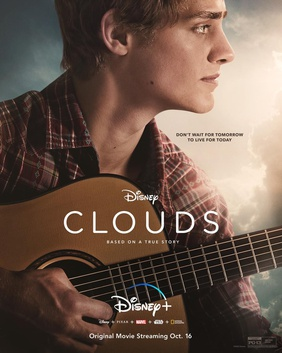

In [159]:
from PIL import Image

some_movie = movies_df.sample()

def get_image(movie_id: int, ) -> Image:
    """
    Get the image for the given movie
    """
    return Image.open(IMAGES_DIR / f"{movie_id}.jpg")

display(some_movie.transpose())
get_image(some_movie.index[0])

## Upload movies!

Now, we have all movies in the `images` folder and the movies data in the `movies.parquet` file.
We can proceed to do a nice little pipeline to send them to Weaviate. 

We will process the embeddings of the movies into a collection, we will vectorize the movies
plots and titles so we can do some RAG or content generation later.

We will use a Weaviate Cloud cluster and use the OpenAI vectorizer, which is easier to use than 
others out there.

In [121]:
import weaviate
from weaviate import WeaviateClient
import os

def weaviate_connect_client() -> WeaviateClient:
    """
    Connect to Weaviate and return the client
    """
    client = weaviate.connect_to_wcs(
        cluster_url=os.environ['WEAVIATE_URL'],
        auth_credentials=weaviate.auth.AuthApiKey(os.getenv("WEAVIATE_API_KEY")),
        headers={
            'X-OpenAI-Api-key': os.getenv("OPENAI_KEY")
        }
    )
    client.connect()
    return client


weaviate_client = weaviate_connect_client()

First, we create the collection (wipe out if it existed before)

In [164]:
from weaviate.classes.config import Configure, DataType, Property, ReferenceProperty


VECTORIZER_MODEL = "text-embedding-3-large"

def create_collections(client: weaviate.Client):
    """
    Create the Movies collection in Weaviate database
    """
    # Movies are OK
    client.collections.delete("Movie")
    client.collections.create(
        name="Movie",
        properties=[
            Property(name="movie_id", data_type=DataType.INT),
            Property(name="title", data_type=DataType.TEXT),
            Property(name="plot", data_type=DataType.TEXT),
        ]
    )

    # Since plots can be big, we import them in chunks
    client.collections.delete("MovieChunk")
    client.collections.create(
        name="MovieChunk",
        vectorizer_config=Configure.Vectorizer.text2vec_openai(
            model=VECTORIZER_MODEL
        ),
        properties=[
            Property(name="chunk", data_type=DataType.TEXT)
        ],
        references=[
            ReferenceProperty(
                name="movie",
                target_collection="Movie"
            )
        ]
    )   


create_collections(weaviate_client)

Check if the collection was created

In [184]:
from weaviate.collections import Collection


def get_movies_collection(client: weaviate.Client) -> Collection:
    """
    Get the Movies collection from the database
    """
    return client.collections.get("Movie")

movies_collection = get_movies_collection(weaviate_client)
movies_collection

Let's go ahead and upload the movies!

Let's try importing a single movie into the batch

In [174]:
import base64
from uuid import UUID


def import_movies(batch, movies: pd.DataFrame):
    """
    Import a movie into the database
    """
    for idx, movie in movies.iterrows():
        properties = {
            "movie_id": int(idx),
            "title": movie['title'],
            "plot": movie['plot']
        }
        the_uuid = UUID(hex=movie['uuid'])
        batch.add_object(collection="Movie", properties=properties, uuid=the_uuid)


some_movie = movies_df.sample()
print("Some movie")
display(some_movie.iloc[0])

with weaviate_client.batch.dynamic() as batch:
    import_movies(batch, some_movie)

Some movie


title                                      Rushmore (film)
image    https://upload.wikimedia.org/wikipedia/en/4/42...
plot     Eccentric 15-year-old scholarship student Max ...
uuid                      204eb4af1e10443797c195c02545ca7a
Name: 2055, dtype: object

We are going to use LangChain to chunk the documents, since plots can be long, and can dillute
the embeddings if we use them over large documents.

We will omit the `DataFrameLoader` and the use of `WeaviateVectorStore` and do stuff more manually,
so we have a more nuanced handling of the collections. 

Now, we import movies using a chunker from Langchain. First we have to figure out which encoding is 
the correct for our encoder. It should be `cl100k_base`

In [146]:
import tiktoken

ENCODING = tiktoken.encoding_name_for_model(VECTORIZER_MODEL)
print(f"Using encoding: {ENCODING}")

Using encoding: cl100k_base


In [147]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from IPython.display import display, HTML

character_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=256, chunk_overlap=32
)

print("Full plot")
some_plot = movies_df.sample()['plot'].values[0]
display(HTML(some_plot))

print("Chunks")
len(character_splitter.split_text(some_plot))

Full plot


Chunks


4

Let's import chunks per movie

In [171]:
from langchain_text_splitters import TextSplitter


def import_movie_chunks(batch, text_splitter: TextSplitter, movies: pd.DataFrame):
    """
    Import the chunks for each movie
    """
    for _, movie in movies.iterrows():
        for chunk in text_splitter.split_text(movie['plot']):
            properties = {
                "chunk": chunk
            }
            refs = { "movie": UUID(hex=movie['uuid']) }
            batch.add_object(collection="MovieChunk", properties=properties, references=refs)

with weaviate_client.batch.dynamic() as batch:
    import_movie_chunks(batch, character_splitter, some_movie)

Now, let's import several movies at once

In [181]:
from tqdm import tqdm

def import_all_movies(client: WeaviateClient, movies: pd.DataFrame):
    """
    Import all movies into the database
    """
    BATCH_SIZE = 10
    with tqdm(total=len(movies), desc="Importing Movies objects", unit="Movie") as pbar, \
            client.batch.dynamic() as batch:
        for start_idx in range(0, len(movies), BATCH_SIZE):
            slice = movies.iloc[start_idx:start_idx + BATCH_SIZE]
            import_movies(batch, slice)
            
            if batch.number_errors > 0:
                pbar.set_postfix_str(f"Errors: {batch.number_errors}")

            pbar.update(len(slice))

    with tqdm(total=len(movies), desc="Importing Movie chunks", unit="Movie") as pbar, \
            client.batch.dynamic() as batch:
        for start_idx in range(0, len(movies), BATCH_SIZE):
            slice = movies.iloc[start_idx:start_idx + BATCH_SIZE]
            import_movie_chunks(batch, character_splitter, slice)
            
            if batch.number_errors > 0:
                pbar.set_postfix_str(f"Errors: {batch.number_errors}")

            pbar.update(len(slice))

        batch.add_object


create_collections(weaviate_client)
import_all_movies(weaviate_client, movies_df)

Importing Movies objects:   1%|          | 170/13722 [00:00<00:08, 1661.76Movie/s]Exception in callback PollerCompletionQueue._handle_events(<_UnixSelecto...e debug=False>)()
handle: <Handle PollerCompletionQueue._handle_events(<_UnixSelecto...e debug=False>)()>
Traceback (most recent call last):
  File "/Users/igui/.pyenv/versions/3.11.8/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "src/python/grpcio/grpc/_cython/_cygrpc/aio/completion_queue.pyx.pxi", line 147, in grpc._cython.cygrpc.PollerCompletionQueue._handle_events
BlockingIOError: [Errno 35] Resource temporarily unavailable
Importing Movies objects:   3%|▎         | 470/13722 [00:05<02:49, 78.35Movie/s]  Exception in callback PollerCompletionQueue._handle_events(<_UnixSelecto...e debug=False>)()
handle: <Handle PollerCompletionQueue._handle_events(<_UnixSelecto...e debug=False>)()>
Traceback (most recent call last):
  File "/Users/igui/.pyenv/versions/3.11.8/lib/py

## Make some queries

Now that we have the movies uploaded, we can do some sample queries to mess around with the API;
in this case, we make an hybrid search just to see how it works. We can use RAG or other techniques
if we wanted.

In [222]:
import itertools
from weaviate.classes.query import MetadataQuery
from weaviate.collections.classes.internal import Object, Properties
from weaviate.classes.query import QueryReference

def query_similar(q: str, alpha: float, limit: int = 5) -> list[Object[Properties, MetadataQuery]]:
    """
    Query the database for similar movies, it returns the chunks and the movie
    But omits duplicated movies. Only the most relevant chunk per movie is returned
    """
    chunk_collection = weaviate_client.collections.get("MovieChunk")
    collected_movies = {}
    for offset in itertools.count(0, step=limit):
        ret = chunk_collection.query.hybrid(
            query=q, 
            alpha=alpha,
            return_properties=['chunk'],
            return_references=QueryReference(
                link_on="Movie", return_properties=["movie_id", "title", "plot"]
            ),
            offset=offset,
            limit=limit,
            return_metadata=["score"]
        )
        if not ret.objects:
            # No more results
            return list(collected_movies.values())
        
        for obj in ret.objects:
            if len(collected_movies) >= limit:
                return list(collected_movies.values())
            
            movie_id = obj.references['movie'].objects[0].properties['movie_id']
            collected_movies.setdefault(movie_id, obj)



for movie_chunk in query_similar("Movie about a robot", alpha=0.7, limit=5):
    movie_ref = movie_chunk.references['movie'].objects[0]
    print(f"{movie_ref.properties['title']} - score: {movie_chunk.metadata.score:.3f}")
    print(movie_chunk.properties['chunk'])
    print()

Robot Stories - score: 0.871
remembers carelessly vacuuming up the now missing wing). She finds the complete female robot shop at a local hobby shop, only to find it is not for sale, as it is very rare. In an act of desperation, she steals the wing, attaches it to Wilson's toy, and pretends to fly it through the air, perhaps as a way to accept that her son is now truly gone, and is making his way toward heaven. To apologize for the theft, she sends all of Wilson's toys to the shop/collector, but keeps the angel like female robot as a way to stay connected to her son, even though she now finally accepts his death.  Machine Love An office worker android, Archie, arrives at a workplace to do computer work. As he attempts to make acquaintance with people in the office workplace, he is rejected and shunned because he is a robot. Bob, the technician in charge of Archie, forgets to turn off Archie one night, letting him wander about the empty office complex after he finishes his work. He spot

Let's do another query and now plotting the images

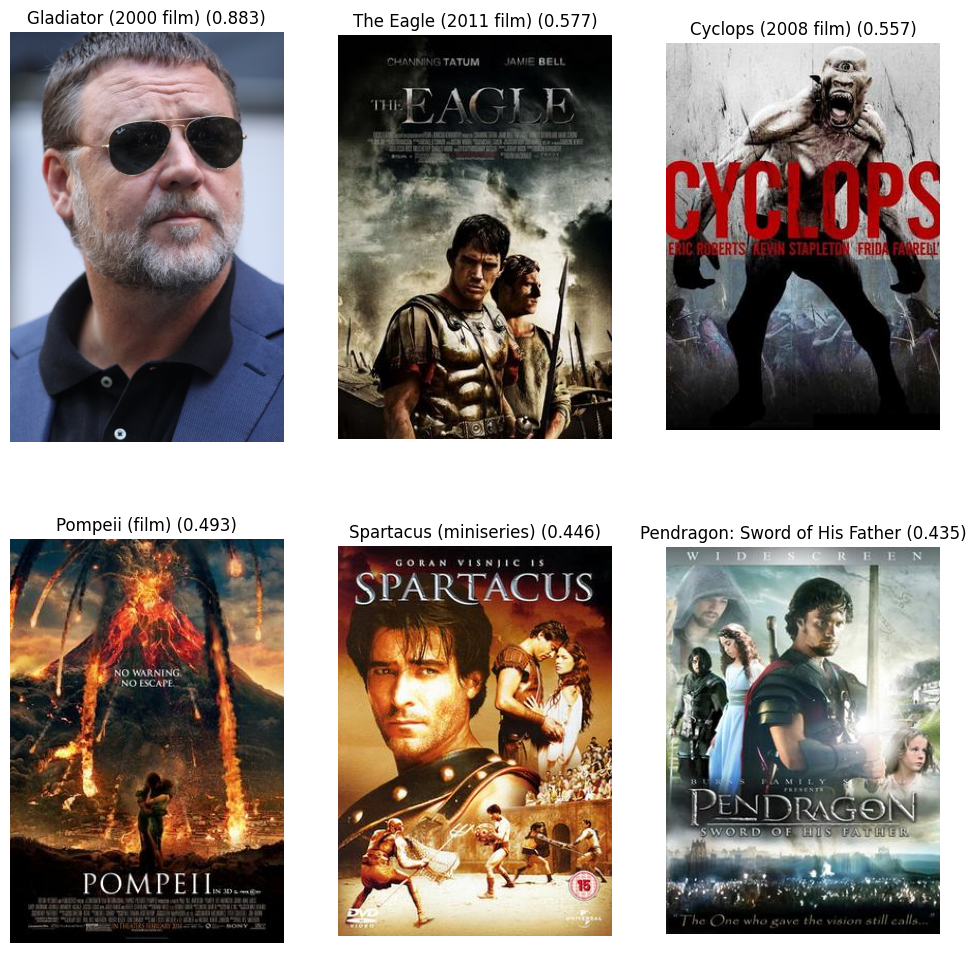

In [221]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

similar_movies = query_similar("Tale about a warrior that fights in Rome", limit=6, alpha=0.7)
imgs = [ 
    get_image(movie_chunk.references['movie'].objects[0].properties['movie_id']) 
    for movie_chunk in similar_movies
]

fig, axs = plt.subplots(2, 3, figsize=(12, 12))
axs: list[Axes] = axs.flatten()
for movie_chunk, img, ax in zip(similar_movies, imgs, axs):
    title = movie_chunk.references['movie'].objects[0].properties['title']
    ax.set_title(f"{title} ({movie_chunk.metadata.score:.3f})")
    ax.set_axis_off()
    ax.imshow(img)

plt.show()

for img in imgs:
    img.close() # Close the handles after we are done with them
